Sometimes, you don't want Yelp to recommend "similar" restaurants per se, but rather restaurants that worth exploring given your rating of the current restaurant. The problem with many recommendation systems including those in popular apps is their focus on *similarity* -- not the differences. Ultimately, however, I don't want to eat the same or have the same experience, but rather I would like to find a "surprisingly good" restaurant that may be a little different. This notion might be a bit hard to quantify, but in this tutorial, I would like to explore very simple techniques for doing this using Yelp Dataset.

We will explore the techniques later in details, but here I would like to highlight the core idea: First, we want to find a way to represent reviews using a bag-of-words representation. After doing so, we will also represent categories using a one-hot encoding representation. Then, we can manipulate those representations to find similarities and differences while balancing the weights of the two. Note that the core idea assume that you are more likely to love a restaurant if its reviews are similar to the reviews of the restaurants you already love.

Let's begin by importing libraries and making sure we only deal with valid data.

In [45]:
import os
import re
import string

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

'''from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
'''
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
yelp_business = pd.read_json('../input/yelp_academic_dataset_business.json', lines=True)
yelp_business.fillna('NA', inplace=True)
# we want to make sure we only work with restaurants -- nothing else
restaurants = yelp_business[yelp_business['categories'].str.contains('Restaurants')]
print('Number of all businesses: ',yelp_business.shape[0])
print(f"Shape of restaurants dataset{restaurants.shape}")

In [46]:
yelp_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
11,2450 E Indian School Rd,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",1,33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ
13,5981 Andrews Rd,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",fweCYi8FmbJXHCqLnwuk8w,"Italian, Restaurants, Pizza, Chicken Wings",Mentor-on-the-Lake,"{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...",1,41.708520,-81.359556,Marco's Pizza,44060,16,4.0,OH
17,"1775 E Tropicana Ave, Ste 29","{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",Las Vegas,NA,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,89119,40,4.0,NV


In [ ]:
restaurants.head()

Now we bring the reviews and perform some preprocessing on those reviews..

In [ ]:
yelp_review_iter = pd.read_json('../input/yelp_academic_dataset_review.json', chunksize=100000, lines=True)


Because reviews are too big, we will read them in chunks, and make sure we delete reviews of places that are not in our list of businesses filtered earlier. Note here we choose 5 chunks, but we could have chosen any number (larger numbers will give MemoryError later on).

In [ ]:
yelp_review = pd.DataFrame()
i=0
for df in yelp_review_iter:
    
    df = df[df['business_id'].isin(restaurants['business_id'])]
    print(df.shape)
    yelp_review = pd.concat([yelp_review, df])
    i=i+1
    print(i)
    if i==20: break

In [ ]:
yelp_review.shape

Also make sure we only get businesses that already show up in our review list and delete the rest.

In [ ]:
import pickle
yelp_review.to_pickle("pickled_reviews.pickle")


In [ ]:
rest_reviews =pd.read_pickle("pickled_reviews.pickle")

In [ ]:
yelp_business = yelp_business[yelp_business['business_id'].isin(rest_reviews['business_id'])]

In [ ]:
print('Final businesses shape: ', yelp_business.shape)
print('Final review shape: ', rest_reviews.shape)

In [47]:
rest_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
5,eU_713ec6fTGNO4BegRaww,0,2013-01-20 13:25:59,0,fdiNeiN_hoCxCMy2wTRW9g,4,I'll be the first to admit that I was not exci...,0,w31MKYsNFMrjhWxxAb5wIw
6,3fw2X5bZYeW9xCz_zGhOHg,5,2016-05-07 01:21:02,4,G7XHMxG0bx9oBJNECG4IFg,3,Tracy dessert had a big name in Hong Kong and ...,5,jlu4CztcSxrKx56ba1a5AQ
7,zvO-PJCpNk4fgAVUnExYAA,1,2010-10-05 19:12:35,1,8e9HxxLjjqc9ez5ezzN7iQ,1,This place has gone down hill. Clearly they h...,3,d6xvYpyzcfbF_AZ8vMB7QA
10,8mIrX_LrOnAqWsB5JrOojQ,0,2011-11-30 02:11:15,0,kbtscdyz6lvrtGjD1quQTg,4,"Like walking back in time, every Saturday morn...",0,FIk4lQQu1eTe2EpzQ4xhBA


In [48]:
rest_reviews['funny'].describe()

count    1.253695e+06
mean     4.736407e-01
std      3.504198e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.290000e+03
Name: funny, dtype: float64

In [51]:
pd.options.display.max_seq_items = 2000
print(rest_reviews[rest_reviews['funny']==1290][['business_id', 'text']])

                    business_id                                               text
1331304  DN0b4Un8--Uf6SEWLeh0UA  Flew to Arizona a few months ago to try this. ...


In [52]:
rest_reviews.loc[1331304,'text']

"Flew to Arizona a few months ago to try this. Disappointed that this place closed after Gordon Ramsay's return. Their food was one of the best food I had in my whole entire life!! Their caesar salad was great, sauce is very good. Their pizza was THE BEST I HAD IN MY WHOLE ENTIRE LIFE. From the garlic crust to the extremely cheesy topping, the pizza was absolutely outstanding. Wish I could come back but its now closed."

In [55]:
rest_reviews['fun_bin']=rest_reviews['funny'].apply(lambda x: 1 if x>0 else 0)

In [57]:
# Check:
print( (rest_reviews['funny']>0).mean())
print(rest_reviews['fun_bin'].mean())

0.1988059296718899
0.1988059296718899


In [59]:
restaurants[restaurants['business_id'] == 'DN0b4Un8--Uf6SEWLeh0UA']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
29433,"7366 E Shea Blvd, Ste 112","{'RestaurantsAttire': 'u'casual'', 'GoodForKid...",DN0b4Un8--Uf6SEWLeh0UA,"Sandwiches, Bakeries, American (New), Italian,...",Scottsdale,"{'Tuesday': '12:0-21:0', 'Wednesday': '12:0-21...",0,33.584012,-111.922265,Amy's Baking Company,85260,546,3.0,AZ


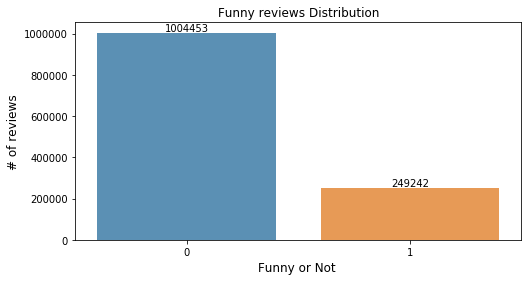

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
x = yelp_review['fun_bin'].value_counts()
x = x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Funny reviews Distribution")
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Funny or Not ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show();